<a href="https://colab.research.google.com/github/raghunadh-eva/eva6/blob/master/S7_ASSIGNMENT/CODE4_84p79_89KPARAM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Basic setup block**


*   Load the required utils/libraries
*   Setup the transformations needed to load the data
*   Split the input data into train and test
*   Create the train and test data objects





In [1]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms, utils
%matplotlib inline
import matplotlib.pyplot as plt
from torch.optim.lr_scheduler import StepLR
!pip install torchsummary
from torchsummary import summary
import numpy as np

In [2]:
!pip install -U albumentations
import albumentations as A
import cv2


import albumentations as A
from albumentations.pytorch import ToTensorV2

Requirement already up-to-date: albumentations in /usr/local/lib/python3.7/dist-packages (1.0.0)


In [3]:
test_transforms  = transforms.Compose([
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.4914,0.4822,0.4465), (0.247,0.2435,0.2616))
                                      ])

In [4]:
train_transforms_a = A.Compose([
                                       A.Normalize(mean=(0.4914, 0.4822, 0.4465), std=(0.247, 0.2435, 0.2616)),
                                       A.HorizontalFlip(p=0.5),
                                       A.ShiftScaleRotate(),
                                       A.CoarseDropout(max_holes=1,max_height=16,max_width=16,min_holes=1,min_height=16,min_width=16,fill_value=(0.4914, 0.4822, 0.4465),mask_fill_value=None),
                                       ToTensorV2()
                                       ])

In [5]:
import cv2
import torchvision

##copied from albumentations.io
cv2.setNumThreads(0)
cv2.ocl.setUseOpenCL(False)

class data_albumentations(datasets.CIFAR10):
    def __init__(self, root="~/data/cifar10", train=True, download=True, transform=None):
        super().__init__(root=root, train=train, download=download, transform=transform)

    def __getitem__(self, index):
        image, label = self.data[index], self.targets[index]

        if self.transform is not None:
            transformed = self.transform(image=image)
            image = transformed["image"]

        return image, label



In [6]:
#train = datasets.CIFAR10('./data', train=True,  download=True, transform=train_transforms)
train = data_albumentations(train=True,  download=True, transform=train_transforms_a)
test =  datasets.CIFAR10('./data', train=False, download=True, transform=test_transforms)


Files already downloaded and verified
Files already downloaded and verified


In [7]:
#Always start with same random set everytime
SEED = 1

#Is GPU ?
cuda = torch.cuda.is_available()

print('CUDA Available?',cuda)

#what happens when SEED = 2 ?
torch.manual_seed(SEED)

#set the seed for GPU device as well
if cuda:
  torch.cuda.manual_seed(SEED)

device = torch.device("cuda" if cuda else "cpu")
print(device)

dataloader_args = dict(shuffle=True, batch_size=128, num_workers=2, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)
#Why change batch_size for CPU - since it should not matter

train_loader = torch.utils.data.DataLoader(train, **dataloader_args)


test_loader  = torch.utils.data.DataLoader(test, **dataloader_args)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

##Why shuffle=false in the example provided ?

CUDA Available? True
cuda


**Visualize the input data with image standardization**


In [8]:
image_loader = torch.utils.data.DataLoader(train, shuffle=True,batch_size=4)

def imshow(img):
    npimg = img.numpy()
    npimg[0] = (npimg[0] * 0.247) + 0.4914
    npimg[1] = (npimg[1] * 0.2435) + 0.4822
    npimg[2] = (npimg[2] * 0.2616) + 0.4465
    #we can use this directly but simply converting to tensor and converting back
    timg = torch.from_numpy(npimg)
    nimg = timg.numpy()
    plt.imshow(np.transpose(nimg, (1, 2, 0)))

# get some random training images
dataiter = iter(image_loader)
images, labels = dataiter.next()

# show images
#imshow(torchvision.utils.make_grid(images))
#print(classes[labels[10]])
#print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

**Visualize the input data without image standardization**



In [9]:
#Comment this block from CODE2 onwards
train_nonorm_transforms = transforms.Compose([
                                       transforms.ToTensor()
                                       #transforms.Normalize((0.1307,), (0.3081,))
                                       #transforms.RandomRotation((-7.0,7.0),fill=(0,)), #Ideally use mean - adding #0 since MNIST dark pixels and no-information around the borders
                                       #transforms.ColorJitter(brightness = 0.1, contrast= 0.1, saturation = 0.1, hue =0.1),
                                       #transforms.Resize((28,28)) #should be before converting to Tensor logically
                                       ])
test_nonorm_transforms  = transforms.Compose([
                                       transforms.ToTensor()
                                       #transforms.Normalize((0.1307,), (0.3081,))
                                       #transforms.RandomRotation((-7.0,7.0),fill=(0,)), #Ideally use mean - adding #0 since MNIST dark pixels and no-information around the borders
                                       #transforms.ColorJitter(brightness = 0.1, contrast= 0.1, saturation = 0.1, hue =0.1)
                                       #transforms.Resize((28,28)) #should be before converting to Tensor logically
                                      ])
train_nonorm = datasets.CIFAR10('./data_nonorm', train=True,  download=True, transform=train_nonorm_transforms)
test_nonorm =  datasets.CIFAR10('./data_nonorm', train=False, download=True, transform=test_nonorm_transforms)
train_loader_nonorm = torch.utils.data.DataLoader(train_nonorm, **dataloader_args)
test_loader_nonorm  = torch.utils.data.DataLoader(test_nonorm, **dataloader_args)

Files already downloaded and verified
Files already downloaded and verified


In [10]:
#chsum = 0
##pbar = tqdm(train_loader_nonorm)

#for index, (data,target) in enumerate(train_loader_nonorm):
#    chsum += data.sum(dim=(0,2,3),keepdim=True)

#mean = chsum / (len(train_nonorm) * 32 *32)
#
#chsum = None
#for index, (data,target) in enumerate(train_loader_nonorm):
#  if index == 0:
#   print(data.min(),data.max())
#   chsum = (data - mean).pow(2).sum(dim=(0,2,3),keepdim=True)
#  else:
#   chsum += (data - mean).pow(2).sum(dim=(0,2,3),keepdim=True)

#std = torch.sqrt(chsum/(len(train_nonorm) * 32 * 32))
#print("Traindata Mean",mean)
#print("Traindata std dev",std)

#chsum = 0

#for index, (data,target) in enumerate(test_loader_nonorm):
#    chsum += data.sum(dim=(0,2,3),keepdim=True)

#mean = chsum / (len(test_nonorm) * 32 *32)

#chsum = None
#for index, (data,target) in enumerate(test_loader_nonorm):
#  if index == 0:
#    chsum = (data - mean).pow(2).sum(dim=(0,2,3),keepdim=True)
#  else:
#   chsum += (data - mean).pow(2).sum(dim=(0,2,3),keepdim=True)

#std = torch.sqrt(chsum/(len(test_nonorm) * 32 * 32))
#print("Test data Mean",mean)
#print("Test data std dev",std)

ship


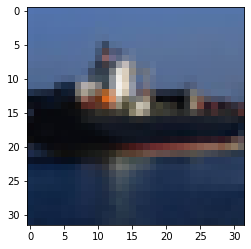

In [11]:
dataiter = iter(train_loader_nonorm)
images, labels = dataiter.next()

def imshow_nonorm(img):
    img = img     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    
# show images
imshow_nonorm(torchvision.utils.make_grid(images[10]))

print(classes[labels[10]])
#print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

**####Batch Normalization + L1 LOSS**

In [12]:
dropout_perc = 0.05

class BatchNormNet(nn.Module):
    def __init__(self):
        super(BatchNormNet, self).__init__()

        #BLOCK C1
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=(3, 3), padding=1, dilation = 1,bias=False),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Dropout(dropout_perc)
        ) 

        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(3, 3), padding=1, dilation = 1,bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Dropout(dropout_perc)
        ) 
        
       #BLOCK C1 TRANSITION
        self.convblock4 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=32, kernel_size=(1, 1), padding=0, bias=False),
        ) 

        #self.pool1 = nn.MaxPool2d(2, 2) # output_size = 16 ; #Receptive field = 8x8
        #Drop maxPooling and use strided convolution
        self.pool1 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(3, 3), stride=2, padding=1, dilation =1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Dropout(dropout_perc)
        )
        #Use dilated kernels instead of Max pooling / stride =2 conv
        self.pool1_dilation = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, groups = 32 , kernel_size=(3, 3), dilation=2, padding=0, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Dropout(dropout_perc),
            nn.Conv2d(in_channels=64, out_channels=128, groups = 128 ,kernel_size=(3, 3), dilation=2, padding=0, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Dropout(dropout_perc),
            nn.Conv2d(in_channels=128, out_channels=256, groups = 128 , kernel_size=(3, 3), dilation=2, padding=0, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Dropout(dropout_perc),
            nn.Conv2d(in_channels=256, out_channels=512, groups = 256 ,kernel_size=(3, 3), dilation=2, padding=0, bias=False),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.Dropout(dropout_perc)
            nn.Conv2d(in_channels=512, out_channels=64, kernel_size=(1, 1), padding=0, bias=False),
        )
        #BLOCK C2
        
        self.convblock5 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128, groups = 64, kernel_size=(3, 3), padding=2, dilation = 2 ,bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Dropout(dropout_perc)
        )
        
        self.convblock6 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=256, groups = 128, kernel_size=(3, 3), padding=2, dilation =2, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Dropout(dropout_perc)
        ) 

        
        #BLOCK C2 TRANSITION
        self.convblock7 = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=32, kernel_size=(1, 1), padding=0, bias=False),
        ) 
        
        
        #self.pool2 = nn.MaxPool2d(2, 2) # output_size = 8 ; #Receptive field = 8x8
        self.pool2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(3, 3), stride=2, padding=1, dilation = 1,bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Dropout(dropout_perc)
        )
        self.pool2_dilation = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, groups = 32, kernel_size=(3, 3), padding=0, dilation =2,bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Dropout(dropout_perc),
            nn.Conv2d(in_channels=64, out_channels=128, groups = 64, kernel_size=(3, 3), padding=0, dilation =2,bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Dropout(dropout_perc),
            nn.Conv2d(in_channels=128, out_channels=64, kernel_size=(1, 1), padding=0,bias=False)
        )

        #BLOCK C3
        
        self.convblock8 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128, groups = 64, kernel_size=(3, 3), padding=2, dilation =2,bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Dropout(dropout_perc)
        )
        
        self.convblock9 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=256, groups = 128, kernel_size=(3, 3), padding=2, dilation=2 , bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Dropout(dropout_perc)
        ) 

        #BLOCK C3 TRANSITION
        self.convblock10 = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=32, kernel_size=(1, 1), padding=0, bias=False),
        ) 
        
        #self.pool2 = nn.MaxPool2d(2, 2) # output_size = 8 ; #Receptive field = 8x8
        self.pool3 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(3, 3), stride=2, padding=1, dilation = 1,bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Dropout(dropout_perc)
        )
        self.pool3_dilation = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, groups=32 , kernel_size=(3, 3), padding=0, dilation = 2,bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Dropout(dropout_perc)
        )
        #BLOCK C4
        
        
        self.convblock11 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128, groups = 64, kernel_size=(3, 3), padding=2, dilation=2 , bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Dropout(dropout_perc)
        ) 
        
        self.convblock12 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=256, groups = 128 , kernel_size=(3, 3), padding=2, dilation =2,bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Dropout(dropout_perc)
        )

        self.convblock25 = nn.Sequential(
            nn.Conv2d(in_channels=256, groups = 256, out_channels=512, kernel_size=(3, 3), padding=2, dilation=2, bias=False)
        ) 

                 
        # OUTPUT BLOCK
        self.gap = nn.Sequential(
            nn.AvgPool2d(kernel_size=4)
        ) # output_size = 1

        self.convblock13 = nn.Sequential(
            nn.Linear(512,10,0)
        )

    def forward(self, x):
        x = self.convblock1(x)
        x = self.convblock2(x)
        x = self.convblock4(x)
        
        x = self.pool1(x)
        
        x = self.convblock5(x)
        x = self.convblock6(x)
        x = self.convblock7(x)

        #x = self.pool2(x)
        x = self.pool2_dilation(x)

        x = self.convblock8(x)
        x = self.convblock9(x)
        x = self.convblock10(x)

        #x = self.pool3(x)
        x = self.pool3_dilation(x)
        
        x = self.convblock11(x)
        x = self.convblock12(x)
        x = self.convblock25(x)
        x = self.gap(x)
        
        x = x.view(x.size(0), -1)
        x = self.convblock13(x)
   
        return F.log_softmax(x, dim=-1)

In [13]:
model = BatchNormNet().to(device)
summary(model, input_size=(3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]             864
       BatchNorm2d-2           [-1, 32, 32, 32]              64
              ReLU-3           [-1, 32, 32, 32]               0
           Dropout-4           [-1, 32, 32, 32]               0
            Conv2d-5           [-1, 64, 32, 32]          18,432
       BatchNorm2d-6           [-1, 64, 32, 32]             128
              ReLU-7           [-1, 64, 32, 32]               0
           Dropout-8           [-1, 64, 32, 32]               0
            Conv2d-9           [-1, 32, 32, 32]           2,048
           Conv2d-10           [-1, 64, 16, 16]          18,432
      BatchNorm2d-11           [-1, 64, 16, 16]             128
             ReLU-12           [-1, 64, 16, 16]               0
          Dropout-13           [-1, 64, 16, 16]               0
           Conv2d-14          [-1, 128,

####LayerNorm Normalization + L1 LOSS

**`####Group normalization network + L1 LOSS`**

In [14]:
from tqdm import tqdm

test_fail_data = []
test_fail_target = []
test_pred_target = []
test_losses = []
test_acc = []
train_acc = []
train_losses = []

loss_function = nn.CrossEntropyLoss()

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)

  l1_lamda = 0.0001
  
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    #Cross entropy loss
    #loss = F.nll_loss(y_pred, target)
    loss = loss_function(y_pred,target)
    #

    ##Add L1 Loss
    l1 = 0
    for p in model.parameters():
      p_tensor = torch.sum(torch.abs(p))
      l1 += p_tensor

    loss = loss + l1_lamda * l1
    
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm
    
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    test_fail_data = []
    test_fail_target = []
    test_pred_target = []

    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            #print(pred,target.view_as(pred))
            correct += pred.eq(target.view_as(pred)).sum().item()
            for i,x in enumerate(pred.eq(target.view_as(pred))):
              if not x:
                test_fail_data.append(data[i])
                test_fail_target.append(target[i])
                test_pred_target.append(pred[i])
                #print(target[i])

    test_losses.append(test_loss)
    
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_acc.append(100. * correct / len(test_loader.dataset))

    return test_losses, test_acc, test_fail_data, test_fail_target, test_pred_target;

**####Block to pass argment and call the Model**

Pass the model to be Invoked based on Input Argument

In [15]:
def main(input_model_type,EPOCHS):
  if input_model_type == 0:
    model = BatchNormNet().to(device)
    test_10_images, test_10_images_target , test_10_pred_target = run_train_test(model,EPOCHS,input_model_type)
    return test_10_images, test_10_images_target , test_10_pred_target ;
  elif input_model_type == 1:
    model = LayerNormNet().to(device)
    test_10_images, test_10_images_target , test_10_pred_target = run_train_test(model,EPOCHS,input_model_type)
    return test_10_images, test_10_images_target , test_10_pred_target ;
  elif input_model_type == 2:
    model = GroupNormNet().to(device)
    test_10_images, test_10_images_target , test_10_pred_target = run_train_test(model,EPOCHS,input_model_type)
    return test_10_images, test_10_images_target , test_10_pred_target ;
  else:
    print("Invalid input for input_model_type",input_model_type)
    print("Supported values are 0 = Batch Norm,1 = Layer Norm,2 = Group Norm")

def run_train_test(model,EPOCHS,input_model_type):
  summary(model, input_size=(3, 32, 32))
  optimizer = optim.SGD(model.parameters(), lr=0.02, momentum=0.9)
  scheduler = optim.lr_scheduler.StepLR(optimizer,step_size=12, gamma=0.7)

  for epoch in range(EPOCHS):
    #print("EPOCH:", epoch)
    
    scheduler.step()
    
    print('Epoch {}, lr {}'.format(
        epoch, optimizer.param_groups[0]['lr']))
    
    train(model, device, train_loader, optimizer, epoch)
    
    test_losses, test_acc, test_fail_data, test_fail_target, test_pred_target = test(model, device, test_loader)
  
  #print(test_fail_data)
  fig, axs = plt.subplots(1, 2)
  if input_model_type == 0:
    fig.suptitle('Model Type: Batch normalization')
  if input_model_type == 1:
    fig.suptitle('Model Type: Layer normalization')
  if input_model_type == 2:
    fig.suptitle('Model Type: Group normalization')
  
  axs[0].set_title('Test/Validation Loss Graph')
  axs[0].set_xticks(np.arange(1,EPOCHS+1))
  #axs[0].xlabel('Test/Validation Loss Graph')
  #axs[0].ylabel('LOSS')
  axs[1].set_title('Test/Validation Accuracy Graph')
  axs[1].set_xticks(np.arange(1,EPOCHS+1))
  #axs[1].xlabel('Test/Validation Accuracy Graph')
  #axs[1].ylabel('Accuracy')
  
  axs[0].plot(test_losses)
  axs[1].plot(test_acc)

  test_10_images = []
  for i in range(0,10):
    test_10_images.append(test_fail_data[i])
  
  test_10_images_target = []
  for i in range(0,10):
    test_10_images_target.append(test_fail_target[i])

  test_10_pred_target = []
  for i in range(0,10):
    test_10_pred_target.append(test_pred_target[i])
  #print(test_10_images_target)

  print('Actual Labels')
  print(' '.join('%5s' % classes[test_10_images_target[j]] for j in range(0,10)))
  print('Predicted Labels')
  print(' '.join('%5s' % classes[test_10_pred_target[j]] for j in range(0,10)))

  test_10_images_unnorm = []
  for img in test_10_images:
    img = img.cpu()
    img = img.numpy()
    img[0] = img[0] * 0.247 + 0.4914
    img[1] = img[1] * 0.2435 + 0.4822
    img[2] = img[2] * 0.2616 + 0.4465

    img = torch.from_numpy(img)
    test_10_images_unnorm.append(img)
  
  grid = torchvision.utils.make_grid(torch.stack(test_10_images_unnorm).cpu(), nrow=5)
  plt.figure(figsize=(5,5))
  plt.imshow(np.transpose(grid, (1,2,0)))

  return test_10_images, test_10_images_target , test_10_pred_target;

**####Call to main function**

main(input_model_type,EPOCHS)

input_model_type:

Supported values are

0 = Train a model with Batch normalization

1 = Train a model with Layer normalization

2 = Train a model with Group Normalization

EPOCHS: num_epochs


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:134: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)
  0%|          | 0/391 [00:00<?, ?it/s]

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]             864
       BatchNorm2d-2           [-1, 32, 32, 32]              64
              ReLU-3           [-1, 32, 32, 32]               0
           Dropout-4           [-1, 32, 32, 32]               0
            Conv2d-5           [-1, 64, 32, 32]          18,432
       BatchNorm2d-6           [-1, 64, 32, 32]             128
              ReLU-7           [-1, 64, 32, 32]               0
           Dropout-8           [-1, 64, 32, 32]               0
            Conv2d-9           [-1, 32, 32, 32]           2,048
           Conv2d-10           [-1, 64, 16, 16]          18,432
      BatchNorm2d-11           [-1, 64, 16, 16]             128
             ReLU-12           [-1, 64, 16, 16]               0
          Dropout-13           [-1, 64, 16, 16]               0
           Conv2d-14          [-1, 128,

Loss=2.314455509185791 Batch_id=390 Accuracy=35.02: 100%|██████████| 391/391 [00:17<00:00, 22.48it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 13374.0534, Accuracy: 5073/10000 (50.73%)

EPOCH: 1
Epoch 1, lr 0.02


Loss=1.8375177383422852 Batch_id=390 Accuracy=48.82: 100%|██████████| 391/391 [00:17<00:00, 22.48it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 11360.9889, Accuracy: 5927/10000 (59.27%)

EPOCH: 2
Epoch 2, lr 0.02


Loss=1.932809829711914 Batch_id=390 Accuracy=53.81: 100%|██████████| 391/391 [00:17<00:00, 22.52it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 11429.0726, Accuracy: 5908/10000 (59.08%)

EPOCH: 3
Epoch 3, lr 0.02


Loss=2.2515807151794434 Batch_id=390 Accuracy=57.05: 100%|██████████| 391/391 [00:17<00:00, 22.47it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 9986.0875, Accuracy: 6411/10000 (64.11%)

EPOCH: 4
Epoch 4, lr 0.02


Loss=1.8384716510772705 Batch_id=390 Accuracy=58.82: 100%|██████████| 391/391 [00:17<00:00, 22.53it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 9510.6909, Accuracy: 6651/10000 (66.51%)

EPOCH: 5
Epoch 5, lr 0.02


Loss=1.6900060176849365 Batch_id=390 Accuracy=60.60: 100%|██████████| 391/391 [00:17<00:00, 22.42it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 8929.0616, Accuracy: 6883/10000 (68.83%)

EPOCH: 6
Epoch 6, lr 0.02


Loss=1.5098072290420532 Batch_id=390 Accuracy=61.81: 100%|██████████| 391/391 [00:17<00:00, 22.33it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 9693.2877, Accuracy: 6602/10000 (66.02%)

EPOCH: 7
Epoch 7, lr 0.02


Loss=1.7132490873336792 Batch_id=390 Accuracy=62.92: 100%|██████████| 391/391 [00:17<00:00, 22.46it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 9947.4447, Accuracy: 6587/10000 (65.87%)

EPOCH: 8
Epoch 8, lr 0.02


Loss=1.8627697229385376 Batch_id=390 Accuracy=63.78: 100%|██████████| 391/391 [00:17<00:00, 22.31it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 8710.1239, Accuracy: 6975/10000 (69.75%)

EPOCH: 9
Epoch 9, lr 0.02


Loss=1.4071283340454102 Batch_id=390 Accuracy=64.66: 100%|██████████| 391/391 [00:17<00:00, 22.50it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 8143.4923, Accuracy: 7187/10000 (71.87%)

EPOCH: 10
Epoch 10, lr 0.02


Loss=1.4335730075836182 Batch_id=390 Accuracy=65.10: 100%|██████████| 391/391 [00:17<00:00, 22.36it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 8592.0512, Accuracy: 7027/10000 (70.27%)

EPOCH: 11
Epoch 11, lr 0.013999999999999999


Loss=1.4341602325439453 Batch_id=390 Accuracy=67.06: 100%|██████████| 391/391 [00:17<00:00, 22.61it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 7980.8923, Accuracy: 7209/10000 (72.09%)

EPOCH: 12
Epoch 12, lr 0.013999999999999999


Loss=1.4346628189086914 Batch_id=390 Accuracy=67.74: 100%|██████████| 391/391 [00:17<00:00, 22.40it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 7443.1619, Accuracy: 7382/10000 (73.82%)

EPOCH: 13
Epoch 13, lr 0.013999999999999999


Loss=1.664612054824829 Batch_id=390 Accuracy=67.79: 100%|██████████| 391/391 [00:17<00:00, 22.35it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 7037.5053, Accuracy: 7574/10000 (75.74%)

EPOCH: 14
Epoch 14, lr 0.013999999999999999


Loss=1.427361249923706 Batch_id=390 Accuracy=68.17: 100%|██████████| 391/391 [00:17<00:00, 22.37it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 7245.5627, Accuracy: 7493/10000 (74.93%)

EPOCH: 15
Epoch 15, lr 0.013999999999999999


Loss=1.6212060451507568 Batch_id=390 Accuracy=68.64: 100%|██████████| 391/391 [00:17<00:00, 22.47it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 6867.6627, Accuracy: 7611/10000 (76.11%)

EPOCH: 16
Epoch 16, lr 0.013999999999999999


Loss=1.5387542247772217 Batch_id=390 Accuracy=68.55: 100%|██████████| 391/391 [00:17<00:00, 22.27it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 7445.9273, Accuracy: 7370/10000 (73.70%)

EPOCH: 17
Epoch 17, lr 0.013999999999999999


Loss=1.5897345542907715 Batch_id=390 Accuracy=69.20: 100%|██████████| 391/391 [00:17<00:00, 22.47it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 7052.3674, Accuracy: 7496/10000 (74.96%)

EPOCH: 18
Epoch 18, lr 0.013999999999999999


Loss=1.3915557861328125 Batch_id=390 Accuracy=69.44: 100%|██████████| 391/391 [00:17<00:00, 22.40it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 6827.1985, Accuracy: 7617/10000 (76.17%)

EPOCH: 19
Epoch 19, lr 0.013999999999999999


Loss=1.4732098579406738 Batch_id=390 Accuracy=69.40: 100%|██████████| 391/391 [00:17<00:00, 22.35it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 6312.5431, Accuracy: 7822/10000 (78.22%)

EPOCH: 20
Epoch 20, lr 0.013999999999999999


Loss=1.270650863647461 Batch_id=390 Accuracy=69.94: 100%|██████████| 391/391 [00:17<00:00, 22.37it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 6324.2225, Accuracy: 7821/10000 (78.21%)

EPOCH: 21
Epoch 21, lr 0.013999999999999999


Loss=1.2871851921081543 Batch_id=390 Accuracy=70.13: 100%|██████████| 391/391 [00:17<00:00, 22.33it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 6540.5612, Accuracy: 7775/10000 (77.75%)

EPOCH: 22
Epoch 22, lr 0.013999999999999999


Loss=1.2212135791778564 Batch_id=390 Accuracy=70.42: 100%|██████████| 391/391 [00:17<00:00, 22.24it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 6208.0421, Accuracy: 7863/10000 (78.63%)

EPOCH: 23
Epoch 23, lr 0.009799999999999998


Loss=1.1400744915008545 Batch_id=390 Accuracy=71.56: 100%|██████████| 391/391 [00:17<00:00, 22.38it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 5980.5093, Accuracy: 7937/10000 (79.37%)

EPOCH: 24
Epoch 24, lr 0.009799999999999998


Loss=1.312821626663208 Batch_id=390 Accuracy=71.50: 100%|██████████| 391/391 [00:17<00:00, 22.25it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 5686.8956, Accuracy: 8034/10000 (80.34%)

EPOCH: 25
Epoch 25, lr 0.009799999999999998


Loss=1.2354450225830078 Batch_id=390 Accuracy=71.78: 100%|██████████| 391/391 [00:17<00:00, 22.15it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 5882.9727, Accuracy: 7964/10000 (79.64%)

EPOCH: 26
Epoch 26, lr 0.009799999999999998


Loss=1.309910535812378 Batch_id=390 Accuracy=71.91: 100%|██████████| 391/391 [00:17<00:00, 22.26it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 6144.9254, Accuracy: 7882/10000 (78.82%)

EPOCH: 27
Epoch 27, lr 0.009799999999999998


Loss=1.418336033821106 Batch_id=390 Accuracy=71.94: 100%|██████████| 391/391 [00:17<00:00, 22.28it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 5894.0222, Accuracy: 7968/10000 (79.68%)

EPOCH: 28
Epoch 28, lr 0.009799999999999998


Loss=1.3853999376296997 Batch_id=390 Accuracy=72.26: 100%|██████████| 391/391 [00:17<00:00, 22.33it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 5866.1341, Accuracy: 7989/10000 (79.89%)

EPOCH: 29
Epoch 29, lr 0.009799999999999998


Loss=1.1635479927062988 Batch_id=390 Accuracy=72.14: 100%|██████████| 391/391 [00:17<00:00, 22.19it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 6166.7816, Accuracy: 7867/10000 (78.67%)

EPOCH: 30
Epoch 30, lr 0.009799999999999998


Loss=1.3425343036651611 Batch_id=390 Accuracy=72.55: 100%|██████████| 391/391 [00:17<00:00, 22.11it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 5529.6438, Accuracy: 8077/10000 (80.77%)

EPOCH: 31
Epoch 31, lr 0.009799999999999998


Loss=1.4040045738220215 Batch_id=390 Accuracy=72.54: 100%|██████████| 391/391 [00:17<00:00, 22.06it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 5865.1165, Accuracy: 7988/10000 (79.88%)

EPOCH: 32
Epoch 32, lr 0.009799999999999998


Loss=1.1803152561187744 Batch_id=390 Accuracy=72.38: 100%|██████████| 391/391 [00:17<00:00, 22.11it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 5851.9759, Accuracy: 7952/10000 (79.52%)

EPOCH: 33
Epoch 33, lr 0.009799999999999998


Loss=1.3395676612854004 Batch_id=390 Accuracy=72.70: 100%|██████████| 391/391 [00:17<00:00, 22.22it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 5688.5192, Accuracy: 8064/10000 (80.64%)

EPOCH: 34
Epoch 34, lr 0.009799999999999998


Loss=1.2402340173721313 Batch_id=390 Accuracy=72.73: 100%|██████████| 391/391 [00:17<00:00, 22.03it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 5730.9555, Accuracy: 8048/10000 (80.48%)

EPOCH: 35
Epoch 35, lr 0.006859999999999998


Loss=1.2513238191604614 Batch_id=390 Accuracy=73.68: 100%|██████████| 391/391 [00:17<00:00, 22.22it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 5609.9454, Accuracy: 8082/10000 (80.82%)

EPOCH: 36
Epoch 36, lr 0.006859999999999998


Loss=1.1891303062438965 Batch_id=390 Accuracy=74.11: 100%|██████████| 391/391 [00:17<00:00, 22.24it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 5327.7010, Accuracy: 8145/10000 (81.45%)

EPOCH: 37
Epoch 37, lr 0.006859999999999998


Loss=1.3140795230865479 Batch_id=390 Accuracy=74.29: 100%|██████████| 391/391 [00:17<00:00, 22.10it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 5440.5636, Accuracy: 8137/10000 (81.37%)

EPOCH: 38
Epoch 38, lr 0.006859999999999998


Loss=1.1221301555633545 Batch_id=390 Accuracy=74.12: 100%|██████████| 391/391 [00:17<00:00, 22.14it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 5456.0116, Accuracy: 8121/10000 (81.21%)

EPOCH: 39
Epoch 39, lr 0.006859999999999998


Loss=1.2752104997634888 Batch_id=390 Accuracy=73.95: 100%|██████████| 391/391 [00:17<00:00, 22.20it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 5554.3338, Accuracy: 8099/10000 (80.99%)

EPOCH: 40
Epoch 40, lr 0.006859999999999998


Loss=1.2240307331085205 Batch_id=390 Accuracy=74.41: 100%|██████████| 391/391 [00:17<00:00, 21.97it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 5084.2940, Accuracy: 8209/10000 (82.09%)

EPOCH: 41
Epoch 41, lr 0.006859999999999998


Loss=1.2484428882598877 Batch_id=390 Accuracy=74.01: 100%|██████████| 391/391 [00:17<00:00, 22.01it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 5348.0296, Accuracy: 8142/10000 (81.42%)

EPOCH: 42
Epoch 42, lr 0.006859999999999998


Loss=1.1986383199691772 Batch_id=390 Accuracy=74.26: 100%|██████████| 391/391 [00:17<00:00, 22.15it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 5747.5597, Accuracy: 8045/10000 (80.45%)

EPOCH: 43
Epoch 43, lr 0.006859999999999998


Loss=0.971307635307312 Batch_id=390 Accuracy=74.04: 100%|██████████| 391/391 [00:17<00:00, 22.00it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 5258.2664, Accuracy: 8159/10000 (81.59%)

EPOCH: 44
Epoch 44, lr 0.006859999999999998


Loss=1.2663681507110596 Batch_id=390 Accuracy=74.25: 100%|██████████| 391/391 [00:17<00:00, 22.16it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 5278.4653, Accuracy: 8196/10000 (81.96%)

EPOCH: 45
Epoch 45, lr 0.006859999999999998


Loss=0.9600930213928223 Batch_id=390 Accuracy=74.48: 100%|██████████| 391/391 [00:17<00:00, 21.93it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 5363.3315, Accuracy: 8152/10000 (81.52%)

EPOCH: 46
Epoch 46, lr 0.006859999999999998


Loss=1.0612221956253052 Batch_id=390 Accuracy=74.24: 100%|██████████| 391/391 [00:17<00:00, 22.03it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 5317.3264, Accuracy: 8194/10000 (81.94%)

EPOCH: 47
Epoch 47, lr 0.004801999999999998


Loss=1.2074965238571167 Batch_id=390 Accuracy=75.58: 100%|██████████| 391/391 [00:17<00:00, 22.14it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 5196.8652, Accuracy: 8205/10000 (82.05%)

EPOCH: 48
Epoch 48, lr 0.004801999999999998


Loss=1.0609701871871948 Batch_id=390 Accuracy=75.60: 100%|██████████| 391/391 [00:17<00:00, 22.16it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 5272.1070, Accuracy: 8220/10000 (82.20%)

EPOCH: 49
Epoch 49, lr 0.004801999999999998


Loss=0.8236833810806274 Batch_id=390 Accuracy=75.61: 100%|██████████| 391/391 [00:17<00:00, 22.04it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 5310.9458, Accuracy: 8199/10000 (81.99%)

EPOCH: 50
Epoch 50, lr 0.004801999999999998


Loss=1.1508140563964844 Batch_id=390 Accuracy=75.39: 100%|██████████| 391/391 [00:17<00:00, 22.11it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 5032.7231, Accuracy: 8284/10000 (82.84%)

EPOCH: 51
Epoch 51, lr 0.004801999999999998


Loss=1.1582237482070923 Batch_id=390 Accuracy=75.40: 100%|██████████| 391/391 [00:17<00:00, 22.10it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 4967.5761, Accuracy: 8322/10000 (83.22%)

EPOCH: 52
Epoch 52, lr 0.004801999999999998


Loss=1.241014003753662 Batch_id=390 Accuracy=75.62: 100%|██████████| 391/391 [00:17<00:00, 22.00it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 4870.6329, Accuracy: 8314/10000 (83.14%)

EPOCH: 53
Epoch 53, lr 0.004801999999999998


Loss=1.1532176733016968 Batch_id=390 Accuracy=75.55: 100%|██████████| 391/391 [00:17<00:00, 22.02it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 5103.2295, Accuracy: 8245/10000 (82.45%)

EPOCH: 54
Epoch 54, lr 0.004801999999999998


Loss=1.0990941524505615 Batch_id=390 Accuracy=75.56: 100%|██████████| 391/391 [00:17<00:00, 22.00it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 5085.8053, Accuracy: 8260/10000 (82.60%)

EPOCH: 55
Epoch 55, lr 0.004801999999999998


Loss=1.0794382095336914 Batch_id=390 Accuracy=76.08: 100%|██████████| 391/391 [00:17<00:00, 22.10it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 5202.4782, Accuracy: 8193/10000 (81.93%)

EPOCH: 56
Epoch 56, lr 0.004801999999999998


Loss=1.3044342994689941 Batch_id=390 Accuracy=75.88: 100%|██████████| 391/391 [00:17<00:00, 22.07it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 4833.2999, Accuracy: 8354/10000 (83.54%)

EPOCH: 57
Epoch 57, lr 0.004801999999999998


Loss=0.9751098155975342 Batch_id=390 Accuracy=75.73: 100%|██████████| 391/391 [00:17<00:00, 21.94it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 5075.8962, Accuracy: 8232/10000 (82.32%)

EPOCH: 58
Epoch 58, lr 0.004801999999999998


Loss=1.1141142845153809 Batch_id=390 Accuracy=75.72: 100%|██████████| 391/391 [00:17<00:00, 22.00it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 5250.1242, Accuracy: 8220/10000 (82.20%)

EPOCH: 59
Epoch 59, lr 0.0033613999999999983


Loss=1.0125277042388916 Batch_id=390 Accuracy=76.43: 100%|██████████| 391/391 [00:17<00:00, 22.06it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 4968.2948, Accuracy: 8303/10000 (83.03%)

EPOCH: 60
Epoch 60, lr 0.0033613999999999983


Loss=0.9703856706619263 Batch_id=390 Accuracy=76.65: 100%|██████████| 391/391 [00:17<00:00, 21.97it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 4923.8307, Accuracy: 8316/10000 (83.16%)

EPOCH: 61
Epoch 61, lr 0.0033613999999999983


Loss=0.9551233649253845 Batch_id=390 Accuracy=76.65: 100%|██████████| 391/391 [00:17<00:00, 22.06it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 5160.1202, Accuracy: 8199/10000 (81.99%)

EPOCH: 62
Epoch 62, lr 0.0033613999999999983


Loss=1.158303141593933 Batch_id=390 Accuracy=76.87: 100%|██████████| 391/391 [00:17<00:00, 22.10it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 4997.2044, Accuracy: 8304/10000 (83.04%)

EPOCH: 63
Epoch 63, lr 0.0033613999999999983


Loss=0.9013350605964661 Batch_id=390 Accuracy=76.68: 100%|██████████| 391/391 [00:17<00:00, 21.97it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 4749.8762, Accuracy: 8362/10000 (83.62%)

EPOCH: 64
Epoch 64, lr 0.0033613999999999983


Loss=1.122330904006958 Batch_id=390 Accuracy=76.88: 100%|██████████| 391/391 [00:17<00:00, 21.87it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 4754.7809, Accuracy: 8350/10000 (83.50%)

EPOCH: 65
Epoch 65, lr 0.0033613999999999983


Loss=1.0795540809631348 Batch_id=390 Accuracy=76.69: 100%|██████████| 391/391 [00:17<00:00, 21.93it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 4863.9170, Accuracy: 8326/10000 (83.26%)

EPOCH: 66
Epoch 66, lr 0.0033613999999999983


Loss=0.9380813837051392 Batch_id=390 Accuracy=76.91: 100%|██████████| 391/391 [00:17<00:00, 21.87it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 4656.2124, Accuracy: 8424/10000 (84.24%)

EPOCH: 67
Epoch 67, lr 0.0033613999999999983


Loss=1.0769292116165161 Batch_id=390 Accuracy=77.03: 100%|██████████| 391/391 [00:17<00:00, 21.84it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 4696.6118, Accuracy: 8394/10000 (83.94%)

EPOCH: 68
Epoch 68, lr 0.0033613999999999983


Loss=0.9577193856239319 Batch_id=390 Accuracy=76.72: 100%|██████████| 391/391 [00:17<00:00, 22.00it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 4839.3988, Accuracy: 8329/10000 (83.29%)

EPOCH: 69
Epoch 69, lr 0.0033613999999999983


Loss=1.082252025604248 Batch_id=390 Accuracy=76.54: 100%|██████████| 391/391 [00:17<00:00, 21.98it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 4747.7498, Accuracy: 8374/10000 (83.74%)

EPOCH: 70
Epoch 70, lr 0.0033613999999999983


Loss=0.8883675932884216 Batch_id=390 Accuracy=76.64: 100%|██████████| 391/391 [00:17<00:00, 21.73it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 4918.5216, Accuracy: 8323/10000 (83.23%)

EPOCH: 71
Epoch 71, lr 0.002352979999999999


Loss=1.09364914894104 Batch_id=390 Accuracy=77.45: 100%|██████████| 391/391 [00:17<00:00, 21.74it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 4647.6973, Accuracy: 8399/10000 (83.99%)

EPOCH: 72
Epoch 72, lr 0.002352979999999999


Loss=0.9848717451095581 Batch_id=390 Accuracy=77.78: 100%|██████████| 391/391 [00:17<00:00, 22.12it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 4582.8959, Accuracy: 8449/10000 (84.49%)

EPOCH: 73
Epoch 73, lr 0.002352979999999999


Loss=0.9245960712432861 Batch_id=390 Accuracy=77.58: 100%|██████████| 391/391 [00:17<00:00, 21.82it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 4629.1227, Accuracy: 8432/10000 (84.32%)

EPOCH: 74
Epoch 74, lr 0.002352979999999999


Loss=1.0920021533966064 Batch_id=390 Accuracy=77.77: 100%|██████████| 391/391 [00:17<00:00, 21.96it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 4853.1472, Accuracy: 8344/10000 (83.44%)

EPOCH: 75
Epoch 75, lr 0.002352979999999999


Loss=1.0920531749725342 Batch_id=390 Accuracy=77.82: 100%|██████████| 391/391 [00:17<00:00, 21.81it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 4562.8745, Accuracy: 8465/10000 (84.65%)

EPOCH: 76
Epoch 76, lr 0.002352979999999999


Loss=1.1906332969665527 Batch_id=390 Accuracy=77.87: 100%|██████████| 391/391 [00:17<00:00, 21.94it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 4834.8146, Accuracy: 8387/10000 (83.87%)

EPOCH: 77
Epoch 77, lr 0.002352979999999999


Loss=0.9936137795448303 Batch_id=390 Accuracy=77.82: 100%|██████████| 391/391 [00:17<00:00, 21.89it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 4667.3604, Accuracy: 8394/10000 (83.94%)

EPOCH: 78
Epoch 78, lr 0.002352979999999999


Loss=0.9953064918518066 Batch_id=390 Accuracy=77.73: 100%|██████████| 391/391 [00:17<00:00, 21.88it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 4815.8166, Accuracy: 8343/10000 (83.43%)

EPOCH: 79
Epoch 79, lr 0.002352979999999999


Loss=1.0613561868667603 Batch_id=390 Accuracy=77.69: 100%|██████████| 391/391 [00:18<00:00, 21.64it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 4734.7793, Accuracy: 8389/10000 (83.89%)

EPOCH: 80
Epoch 80, lr 0.002352979999999999


Loss=1.2483153343200684 Batch_id=390 Accuracy=77.94: 100%|██████████| 391/391 [00:17<00:00, 21.81it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 4813.6846, Accuracy: 8341/10000 (83.41%)

EPOCH: 81
Epoch 81, lr 0.002352979999999999


Loss=0.8958873152732849 Batch_id=390 Accuracy=77.92: 100%|██████████| 391/391 [00:17<00:00, 21.84it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 4654.2214, Accuracy: 8411/10000 (84.11%)

EPOCH: 82
Epoch 82, lr 0.002352979999999999


Loss=1.055802822113037 Batch_id=390 Accuracy=77.47: 100%|██████████| 391/391 [00:18<00:00, 21.68it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 4848.1367, Accuracy: 8328/10000 (83.28%)

EPOCH: 83
Epoch 83, lr 0.0016470859999999992


Loss=1.0351372957229614 Batch_id=390 Accuracy=78.06: 100%|██████████| 391/391 [00:17<00:00, 21.74it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 4503.4705, Accuracy: 8479/10000 (84.79%)

EPOCH: 84
Epoch 84, lr 0.0016470859999999992


Loss=1.0199462175369263 Batch_id=390 Accuracy=78.69: 100%|██████████| 391/391 [00:17<00:00, 21.79it/s]



Test set: Average loss: 4490.5392, Accuracy: 8462/10000 (84.62%)

Actual Labels
  cat   car  bird   car  bird  deer  frog plane plane plane
Predicted Labels
 bird truck  frog  deer  deer plane  bird  ship  ship  ship


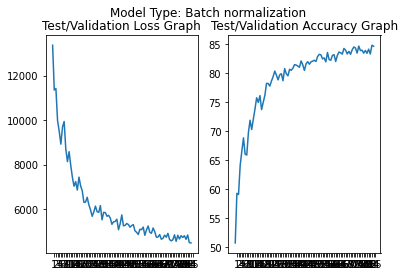

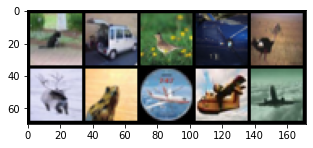

In [16]:
test_10_images, test_10_images_target , test_10_pred_target = main(0,85)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


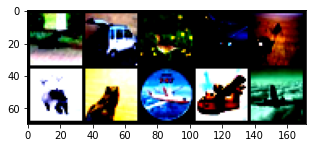

In [17]:
  grid = torchvision.utils.make_grid(torch.stack(test_10_images).cpu(), nrow=5)
  plt.figure(figsize=(5,5))
  plt.imshow(np.transpose(grid, (1,2,0)))

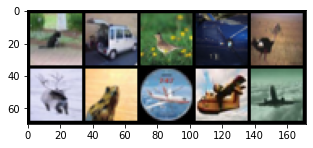

In [18]:
test_10_images_unnorm = []
for img in test_10_images:
  img = img.cpu()
  img = img.numpy()
  img[0] = img[0] * 0.247 + 0.4914
  img[1] = img[1] * 0.2435 + 0.4822
  img[2] = img[2] * 0.2616 + 0.4465

  img = torch.from_numpy(img)
  test_10_images_unnorm.append(img)

grid = torchvision.utils.make_grid(torch.stack(test_10_images_unnorm).cpu(), nrow=5)
plt.figure(figsize=(5,5))
plt.imshow(np.transpose(grid, (1,2,0)))
  
